Utilities
============

In this notebook we will demonstrate how to use the in-built integral functions to solve volume and surface integrals in underworld. These functions are essential when working in parallel, since information is spread across multiple processes and needs to be carefully shared to solve the integrals.

This notebook also looks at the other main functionality in the utilities, writing xdmf output.

**This notebook is broken down into the following examples:**

1. volumes integrals
2. surface integrals
3. xdmf writing

**Keywords:** underworld utilities, volume integrals, surface integrals, xdmf



In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math

**Setup basic system**

Create mesh and finite element variables

In [2]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (32, 32), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))
temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )

Make up some temperature and velocity field examples

In [3]:
boxMid = (0.5, 0.5)
alpha = 4.0
tempMax = 1.0
velMax = 1.0
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = tempMax * (1. - coord[1])
    xoffset = (coord[0] - boxMid[0], coord[1] - boxMid[1])
    r2 = xoffset[0]*xoffset[0] + xoffset[1]*xoffset[1]
    theta = math.atan2(xoffset[1], xoffset[0])
    vmag = velMax * math.exp(-(r2*alpha)**2.0)
    velocityField.data[index][0] = vmag  * (math.sin( theta ))
    velocityField.data[index][1] = -vmag * (math.cos( theta ))

Plot temperature and velocity field


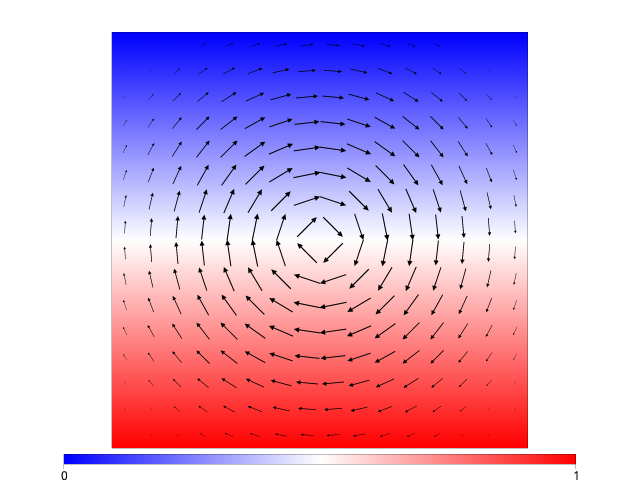

In [4]:
fig1 = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField/(1.5*velMax), arrowHead=0.2, scaling=0.1) )
fig1.append( glucifer.objects.Surface( mesh, temperatureField, colours="blue white red" ) )
fig1.show()

Now we will use this temperature and velocity field with our analysis tools provided by underworld.

Volume integrals
-------

**RMS velocity**

The non-dimensional, root mean squared velocity as calculated over total volume is a standard diagnostic test for fluid dynamics models. It is defined by intergrating over the entire simulation domain via
\\[
\begin{aligned}
v_{rms} & = \frac{h}{\kappa} \left[ \frac{1}{hl} \int_0^l \int_0^h (u^2 + w^2) dz dx  \right]^{1/2} \\
 & =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]
where $V$ denotes the entire 'volume' of the box, which is the x, z surface for a 2D simulation.

This can be easily set up using the ``Integral`` command in the utilities (``utils``) group of functions. In the example below we set up a new scalar feild to be $= {\bf v} \dot {\bf v}$ then use this as the function to integrate over the mesh. For the denominator in the above equation we define the volume integral using the function set to one, so the output will be the entire volume of the simulation domain.

In [5]:
vdotv = fn.math.dot( velocityField, velocityField )
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )

Once these integral functions are set up they can be evaluated at any time. This is typically done inside the main simulation time loop. Here they are used on the sample velocity field to calculate $v_{rms}$.

In [6]:
v2sum  = v2sum_integral.evaluate()
volume = volume_integral.evaluate()
v_rms  = math.sqrt( v2sum[0] )/volume[0]
print('RMS velocity = {0:.3f}'.format(v_rms))

RMS velocity = 0.691


**Volume integral of a sub section**

But what if we only want to integrate over a sub section of the simulation domain? We can also use underworld functions to define a section of the space as a type of filter. In this case we will define a circle (sphere if in 3D) in space where the function is 1 inside and 0 outside the circle.

In [7]:
def circleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2

# Set up the condition for being in a circle. If not in sphere then will return light index.
sphereRadius = 0.1
sphereCentre = (0.5, 0.5)

# setup a function that is 1 if the coordinates, stored in fn.input(), are inside the circle, and zero otherwise.
conditions = [ ( circleFnGenerator( sphereCentre, sphereRadius) , 1.0), 
               ( True                                           , 0.0) ]
kernelFunction = fn.branching.conditional( conditions )

Integrating over this function, over the entire mesh, will give the area of the circle ($\pi r^2$).

In [8]:
area = math.pi * (sphereRadius**2.0)
volume_integral = uw.utils.Integral( mesh=mesh, fn=kernelFunction )
volume = volume_integral.evaluate()
print('Mesh resolution    = {0:4d}'.format(mesh.elementRes[0]))
print('Area from integral = {0:6.8e}'.format(volume[0]))
print('Area from theory   = {0:6.8e}'.format(area))
print('Error (int-th)     = {0:6.8e}'.format(volume[0] - area))


Mesh resolution    =   32
Area from integral = 3.02734375e-02
Area from theory   = 3.14159265e-02
Error (int-th)     = -1.14248904e-03


**Source of error**

Notice that the area is not exactly as expected. This is due to the mesh resolution not properly resolving the edges of the circle. This effect is clear in the figure below where the relative error is plotted against the mesh resolution.
![](Figures/ResError.png)
The integral functions evaluate the function along the mesh vertices of a cartesian coordinate grid. So if the circle only has a few mesh vertices inside it then the calculated area of the circle will be very inaccurate.

**Average of a quantity over a shape**

We can use the same kernel function approach to calculate the average of a quantity (say temperature) over a specified volume/shape. This is equivalent to finding the mean of a quantity ($T$) using
$$
    T_{mean} = \int T( {\bf x} ) f( {\bf x} ) d{\bf x}
$$
where ${\bf x}$ denotes a position in space and $f({\bf x})$ is the kernel function which defines the boundary of the shape. This function can also be used to provide a weighted average.

In [9]:
volume_integral = uw.utils.Integral( mesh=mesh, fn=kernelFunction*temperatureField )
volume = volume_integral.evaluate()
print('Average temperature inside circle from integral = {0:6.8e}'.format(volume[0]))

Average temperature inside circle from integral = 1.51367188e-02


Surface integrals
------

**Nusselt number**


The Nusselt number is a commonly used simulation probe. It is defined as the ratio between convective and conductive heat transfer and can be calculated by the following surface integral
\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]
where $h$/$l$ is the height/length of the simulation domain.

These two integrals are solved in the following cell using the temperature field and it's associated gradient. The vertical component (in 2D) of the gradient function can be accessed by the index 1, while the horizontal (x component) is index 0.

Note that surface integrals can only be used along special set mesh indices, i.e. the boundaries.

In [10]:
nuTop    = uw.utils.Integral( fn=temperatureField.gradientFn[1], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuBottom = uw.utils.Integral( fn=temperatureField,               mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

Once again we activate these integrals using the ``evaluate`` function.

In [11]:
nu = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]
print('Nusselt number = {0:.6f}'.format(nu))

Nusselt number = 1.000000


As with the volume integral the same method of changing the function to be integrated over can be used to integrate over sub sets of the surface of interest. 

Writing to XDMF files
-----

Many analysis software tools such as ``ParaView`` use eXtensible Data Model and Format (``XDMF``) files as their standard for inputting data. Writing to XDMF is supported in underworld via the ``uw.utils.xdmf_write`` function.

Firstly we will setup a directory path for the output files. Note that the latter part of the cell will check to see if the directory already exists, and create it if it doesn't.

In [12]:
outputPath = 'xdmfTest/'
# Make output directory if necessary
import os
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

Next we setup the fields that we want to output in xdmf files. The cell below provides an object containing all the fields we wish to output as well as some human readable names for the output fields. These name labels will be accessed by ``ParaView`` etc, so it is important to set these correctly.

**Note: Swarms are currently not supported in writing XDMF files.**

In [13]:
outputField = { 'velocity'    : velocityField,
                'temperature' : temperatureField }

**Write XDMF file**

The command below will write the XDMF file for the list of fields set above across the specified mesh. The resulting files (xmf, xdmf and h5) are all written in the specified ``outputPath`` directory.

This command is typically used inside a simulation loop, where the time is changing as the model progresses. Here we set the time equal to zero for the output. 

In [14]:
time = 0.0
uw.utils.xdmf_write( outputField, mesh, time=time, outputDir=outputPath )

For more details on using XDMF write and to see it in a dynamical simulation context, see the tutorial **1_06_Rayleigh_Taylor**.